# Decoding Strategies with LLMs

*Notebook based on*: https://huggingface.co/blog/mlabonne/decoding-strategies

- tune important hyper-parameters like *temperature*, *num_beams*, *top_k*, and *top_p*.

## Install & Imports

In [59]:
#! brew install graphviz
! brew --prefix graphviz
! export PATH=$(brew --prefix graphviz):$PATH
! export CFLAGS="-I $(brew --prefix graphviz)/include"
! export LDFLAGS="-L $(brew --prefix graphviz)/lib"
! pip install pygraphviz

/opt/homebrew/opt/graphviz
  Using cached pygraphviz-1.14.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  error: subprocess-exited-with-error
  
  × Building wheel for pygraphviz (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [100 lines of output]
      /private/var/folders/3p/dy76shxx6y9c0frycpgpl4sw0000gn/T/pip-build-env-5_8gbagd/overlay/lib/python3.12/site-packages/setuptools/config/_apply_pyprojecttoml.py:82: SetuptoolsDeprecationWarning: `project.license` as a TOML table is deprecated
      !!
      
              ********************************************************************************
              Please use a simple string containing a SPDX expression for `project.license`. You can also use `project.license-files`. (Both options available on setuptools>=77.0.0).
      
              By 2026-Feb-18, you need to update your project and remove depreca

In [ ]:
! pip install nltk torch transformers pygraphviz tqdm

In [49]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time
import torch

if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")
print(device)

cpu


In [39]:
from transformers import GPT2LMHeadModel, GPT2Tokenizer

model_type = "gpt2"
model = GPT2LMHeadModel.from_pretrained(model_type)
tokenizer = GPT2Tokenizer.from_pretrained(model_type)
model.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D(nf=2304, nx=768)
          (c_proj): Conv1D(nf=768, nx=768)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D(nf=3072, nx=768)
          (c_proj): Conv1D(nf=768, nx=3072)
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=768, out_features=50257, bias=False)
)

In [40]:
text = "I have a dream"
input_ids = tokenizer.encode(text, return_tensors="pt").to(device)
input_ids

tensor([[  40,  423,  257, 4320]])

In [41]:
outputs = model.generate(input_ids, max_length = len(input_ids.squeeze())+5)
generated_text = tokenizer.decode(outputs[0], skip_special_tokens=True)
generated_text

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


'I have a dream of being a doctor.'

# Samplers

In [65]:
def greedy_sampling(logits: torch.Tensor, beams: int) -> torch.Tensor:
    return torch.topk(logits, beams, dim=-1).indices

def top_k_sampling(logits: torch.Tensor, temperature: float, top_k: int, beams: int):
    assert top_k >= 1
    assert beams <= top_k

    indices_to_remove = logits < torch.topk(logits, top_k)[0][..., -1, None]
    new_logits = torch.clone(logits)
    new_logits[indices_to_remove] = float('-inf')

    # Convert logits to probabilities
    probabilities = torch.nn.functional.softmax(new_logits / temperature, dim=-1)

    # Sample n tokens from the resulting distribution
    next_tokens = torch.multinomial(probabilities, beams)

    return next_tokens

def nucleus_sampling(logits: torch.Tensor, temperature: float, p: float, beams: int):
    assert 0 < p <= 1

    # Sort the probabilities in descending order and compute cumulative probabilities
    sorted_logits, sorted_indices = torch.sort(logits, descending=True)
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    cumulative_probabilities = torch.cumsum(probabilities, dim=-1)

    # Create a mask for probabilities that are in the top-p
    mask = cumulative_probabilities < p

    # If there's not n index where cumulative_probabilities < p, use the top n tokens instead
    if mask.sum() > beams:
        top_p_index_to_keep = torch.where(mask)[0][-1].detach().cpu().tolist()
    else:
        top_p_index_to_keep = beams

    # Only keep top-p indices
    indices_to_remove = sorted_indices[top_p_index_to_keep:]
    sorted_logits[indices_to_remove] = float('-inf')

    # Sample n tokens from the resulting distribution
    probabilities = torch.nn.functional.softmax(sorted_logits / temperature, dim=-1)
    next_tokens = torch.multinomial(probabilities, beams)

    return next_tokens


## Greedy

In [45]:
def log_prob(logits:torch.Tensor, token_id:int)->float:
    log_probs = torch.nn.functional.log_softmax(logits, dim=0)
    return log_probs[token_id].item()

# Parameters
length = 5
beams = 1

# Create a balanced tree with height 'length'
graph = nx.balanced_tree(1, length, create_using=nx.DiGraph())

def greedy_search(input_ids, node, length=5):
    if length == 0:
        return input_ids

    outputs = model(input_ids)
    predictions = outputs.logits

    # The predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]
    token_id = torch.argmax(logits).unsqueeze(0)

    # Compute the score of the predicted token
    token_score = log_prob(logits, token_id)

    # Add the predicted token to the list of input ids
    new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0)], dim=-1)

    # Add node and edge to graph
    next_token = tokenizer.decode(token_id, skip_special_tokens=True)
    current_node = list(graph.successors(node))[0]
    graph.nodes[current_node]['tokenscore'] = np.exp(token_score) * 100
    graph.nodes[current_node]['token'] = next_token + f"_{length}"

    # Recursive call
    input_ids = greedy_search(new_input_ids, current_node, length-1)
    
    return input_ids


In [46]:
for node in graph.nodes:
    graph.nodes[node]['tokenscore'] = 100
    graph.nodes[node]['token'] = text

In [47]:
# Start generating text
output_ids = greedy_search(input_ids, 0, length=length)
output = tokenizer.decode(output_ids.squeeze().tolist(), skip_special_tokens=True)
print(f"Generated text: {output}")

Generated text: I have a dream of being a doctor.


ImportError: requires pygraphviz http://pygraphviz.github.io/

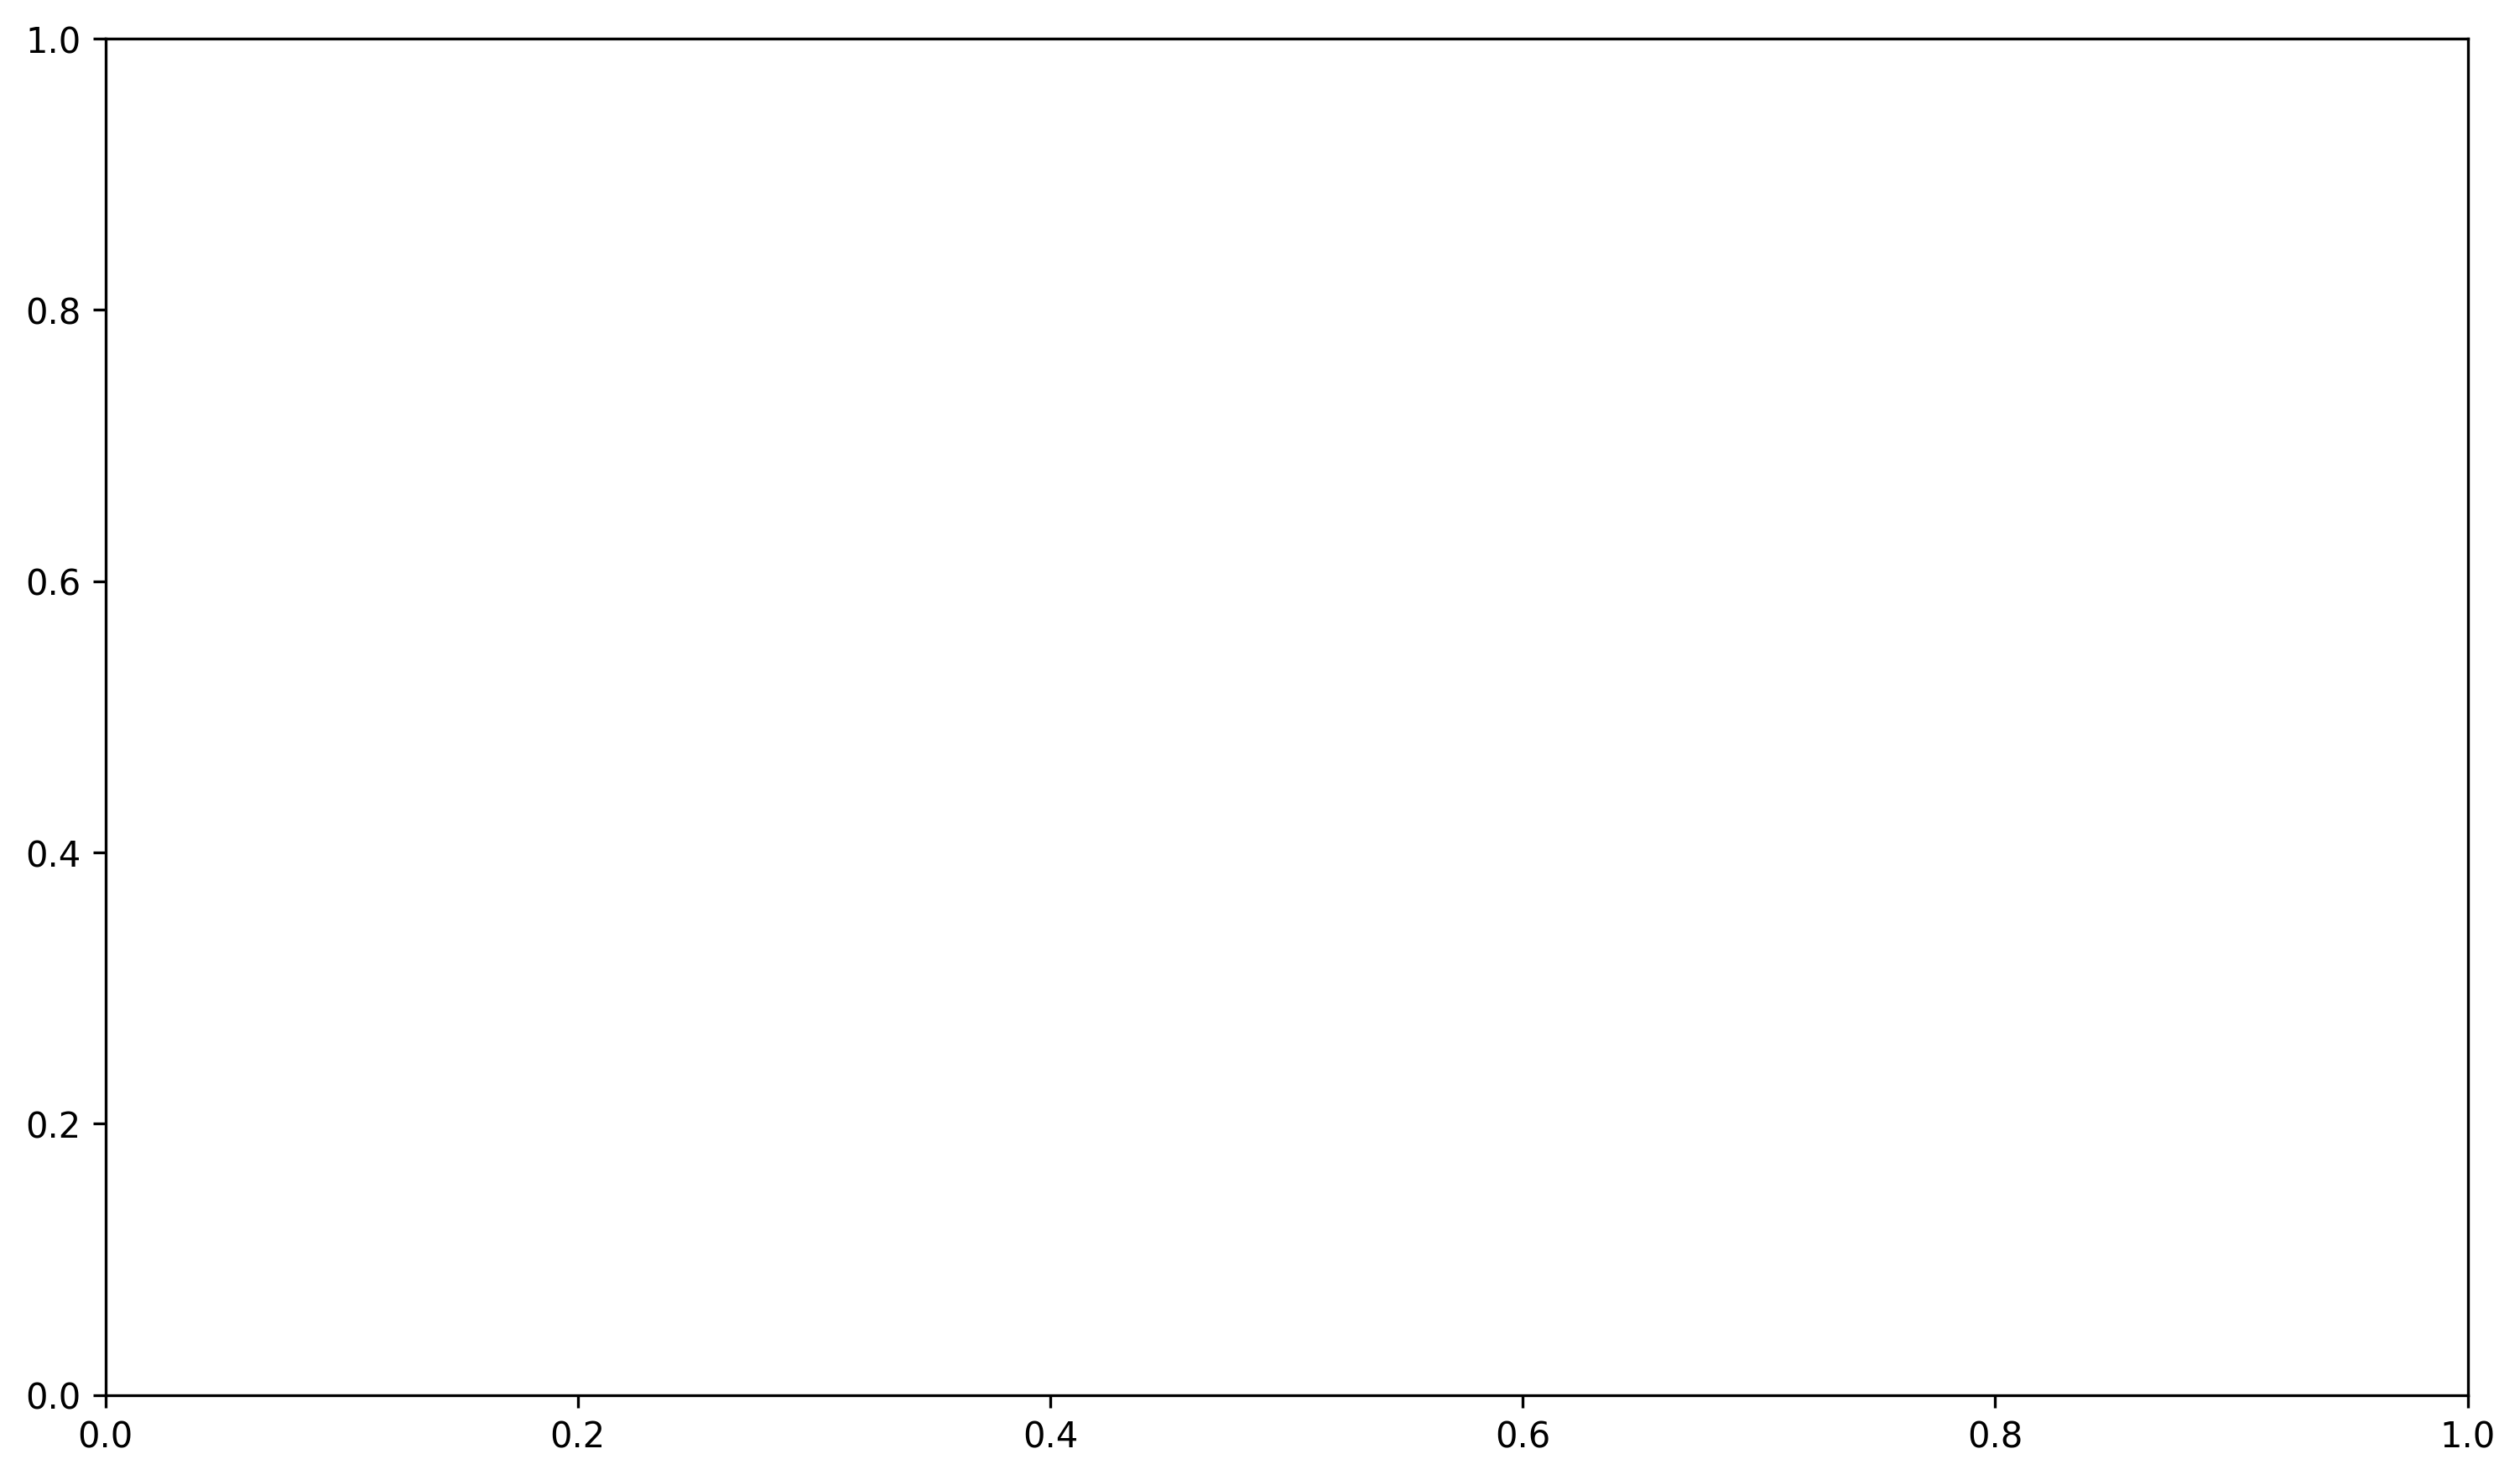

In [50]:
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap


def plot_graph(graph, length, beams, score):
    fig, ax = plt.subplots(figsize=(3+1.2*beams**length, max(5, 2+length)), dpi=300, facecolor='white')

    # Create positions for each node
    pos = nx.nx_agraph.graphviz_layout(graph, prog="dot")

    # Normalize the colors along the range of token scores
    if score == 'token':
        scores = [data['tokenscore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    elif score == 'sequence':
        scores = [data['sequencescore'] for _, data in graph.nodes(data=True) if data['token'] is not None]
    vmin = min(scores)
    vmax = max(scores)
    norm = mcolors.Normalize(vmin=vmin, vmax=vmax)
    cmap = LinearSegmentedColormap.from_list('rg', ["r", "y", "g"], N=256) 

    # Draw the nodes
    nx.draw_networkx_nodes(graph, pos, node_size=2000, node_shape='o', alpha=1, linewidths=4, 
                          node_color=scores, cmap=cmap)

    # Draw the edges
    nx.draw_networkx_edges(graph, pos)

    # Draw the labels
    if score == 'token':
        labels = {node: data['token'].split('_')[0] + f"\n{data['tokenscore']:.2f}%" for node, data in graph.nodes(data=True) if data['token'] is not None}
    elif score == 'sequence':
        labels = {node: data['token'].split('_')[0] + f"\n{data['sequencescore']:.2f}" for node, data in graph.nodes(data=True) if data['token'] is not None}
    nx.draw_networkx_labels(graph, pos, labels=labels, font_size=10)
    plt.box(False)

    # Add a colorbar
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    if score == 'token':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Token probability (%)')
    elif score == 'sequence':
        fig.colorbar(sm, ax=ax, orientation='vertical', pad=0, label='Sequence score')
    plt.show()

# Plot graph
plot_graph(graph, length, 1.5, 'token')

## Beam Search

Unlike greedy search, which only considers the next most probable token, beam search takes into account the $n$ most likely tokens, where $n$ represents the number of beams. This procedure is repeated until a predefined maximum length is reached or an end-of-sequence token appears. At this point, the sequence (or "beam") with the highest overall score is chosen as the output.

In [64]:
def beam_search(input_ids, length, beams, sampling, temperature=0.1):
    if length == 0:
        return None

    outputs = model(input_ids)
    predictions = outputs.logits

    # Get the predicted next sub-word (here we use top-k search)
    logits = predictions[0, -1, :]

    if sampling == 'greedy':
        top_token_ids = greedy_sampling(logits, beams)
    elif sampling == 'top_k':
        top_token_ids = top_k_sampling(logits, temperature, 20, beams)
    elif sampling == 'nucleus':
        top_token_ids = nucleus_sampling(logits, temperature, 0.5, beams)

    for j, token_id in enumerate(top_token_ids):

        # Compute the score of the predicted token
        token_score = log_prob(logits, token_id)
        cumulative_score = graph.nodes[node]['cumscore'] + token_score

        # Add the predicted token to the list of input ids
        new_input_ids = torch.cat([input_ids, token_id.unsqueeze(0).unsqueeze(0)], dim=-1)

        # Add node and edge to graph
        token = tokenizer.decode(token_id, skip_special_tokens=True)

        # Recursive call
        beam_search(new_input_ids, length-1, beams, sampling, 1)

# Parameters
length = 5
beams = 2

# Start generating text
beam_search(input_ids, length, beams, 'greedy', 1)
